# Correlation coefficient tests for screen and frame image data

In [1]:
from itertools import islice

import cv2 as cv
from dateutil.parser import parse as datetime_parse
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from video699.common import COLOR_RGBA_TRANSPARENT
from video699.screen.annotated import AnnotatedScreenDetector
from video699.video.annotated import get_videos

def get_nth(iterator, n):
    return next(islice(iterator, n - 1, n))

## Correlation coefficients with image registration by small translations

In [2]:
MAX_OFFSET = 20  # Maximize the correlation by translating the page image by at most MAX_OFFSET in any direction.

def display(screen, correct_page, incorrect_page, figure_pathname):
    screen_image_gray = cv.cvtColor(screen.image, cv.COLOR_RGBA2GRAY)
    screen_image_alpha = screen.image[:,:,3]
    
    correct_page_translations = []
    incorrect_page_translations = []
    incorrect_page_alpha = incorrect_page.image(screen.width, screen.height)[:,:,3]
    for x in range(-MAX_OFFSET, MAX_OFFSET + 1):
        for y in range(-MAX_OFFSET, MAX_OFFSET + 1):
            transform_matrix = np.float32([[1, 0, x], [0, 1, y]])
            
            correct_page_image = cv.warpAffine(
                correct_page.image(screen.width, screen.height),
                transform_matrix,
                (screen.width, screen.height),
                borderMode=cv.BORDER_CONSTANT,
                borderValue=COLOR_RGBA_TRANSPARENT,
                flags=cv.INTER_LINEAR,
            )
            correct_page_image_gray = cv.cvtColor(correct_page_image, cv.COLOR_RGBA2GRAY)
            correct_page_image_alpha = correct_page_image[:,:,3]
            nonzero_alpha = np.minimum(screen_image_alpha, correct_page_image_alpha).nonzero()
            correct_page_translations.append((
                pearsonr(screen_image_gray[nonzero_alpha], correct_page_image_gray[nonzero_alpha]),
                spearmanr(screen_image_gray[nonzero_alpha], correct_page_image_gray[nonzero_alpha]),
                correct_page_image_gray,
            ))
            
            incorrect_page_image = cv.warpAffine(
                incorrect_page.image(screen.width, screen.height),
                transform_matrix,
                (screen.width, screen.height),
                borderMode=cv.BORDER_CONSTANT,
                borderValue=COLOR_RGBA_TRANSPARENT,
                flags=cv.INTER_LINEAR,
            )
            incorrect_page_image_gray = cv.cvtColor(incorrect_page_image, cv.COLOR_RGBA2GRAY)
            incorrect_page_image_alpha = incorrect_page_image[:,:,3]
            nonzero_alpha = np.minimum(screen_image_alpha, incorrect_page_image_alpha).nonzero()
            incorrect_page_translations.append((
                pearsonr(screen_image_gray[nonzero_alpha], incorrect_page_image_gray[nonzero_alpha]),
                spearmanr(screen_image_gray[nonzero_alpha], incorrect_page_image_gray[nonzero_alpha]),
                incorrect_page_image_gray,
            ))
    
    correct_page_pearsonr, correct_page_spearmanr, correct_page_image_gray = max(
        correct_page_translations,
        key=lambda x: x[1][0],
    )    
    incorrect_page_pearsonr, incorrect_page_spearmanr, incorrect_page_image_gray = max(
        incorrect_page_translations,
        key=lambda x: x[1][0],
    )

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1).imshow(screen_image_gray, cmap='gray')
    plt.subplot(2, 3, 2).imshow(correct_page_image_gray, cmap='gray')
    plt.subplot(2, 3, 3).imshow(incorrect_page_image_gray, cmap='gray')

    plt.subplot(2, 3, 4).hist(screen_image_gray[screen_image_alpha.nonzero()], range=(0, 256), bins=256)
    plt.subplot(2, 3, 5).hist(
        correct_page_image_gray[correct_page_image_alpha.nonzero()],
        range=(0, 256),
        bins=256,
    )
    plt.subplot(2, 3, 6).hist(
        incorrect_page_image_gray[incorrect_page_image_alpha.nonzero()],
        range=(0, 256),
        bins=256,
    )

    plt.savefig(figure_pathname)

    print("Pearson's r between left and middle images:  {}".format(*correct_page_pearsonr))
    print("Spearman's r between left and middle images: {}".format(*correct_page_spearmanr))

    print()
    
    print("Pearson's r between left and right images:  {}".format(*incorrect_page_pearsonr))
    print("Spearman's r between left and right images: {}".format(*incorrect_page_spearmanr))

Computing correlation coefficients with an exhaustive search for a small translation that maximizes Spearman's correlation coefficient is not sufficiently robust as seen in the second example.

Pearson's r between left and middle images:  0.8675681417157906
Spearman's r between left and middle images: 0.6977379863524821

Pearson's r between left and right images:  0.8129194865322433
Spearman's r between left and right images: 0.5521835984257117


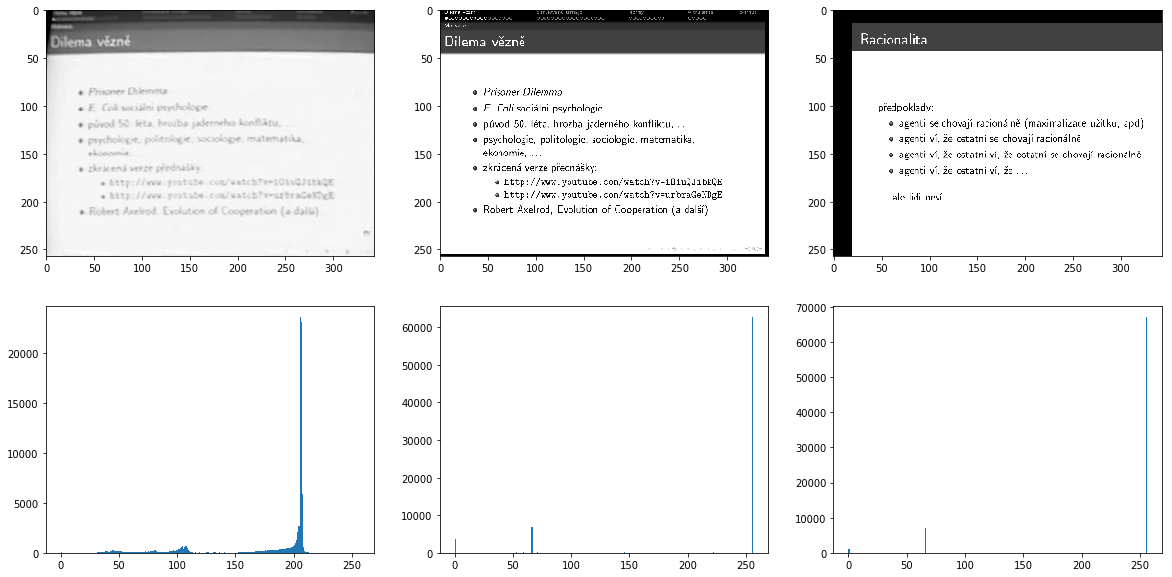

In [3]:
video = get_videos()['https://is.muni.cz/auth/el/1433/jaro2016/IV109/um/vi/?videomuni=IV109-D2-20160406.mp4']
frame = get_nth(video, 8)
screen, *_ = sorted(
    AnnotatedScreenDetector('fimu', 'd2', 'default_2004').detect(frame),
    key=lambda screen: screen.coordinates,
)
correct_page = get_nth(video.documents['slides02.pdf'], 3)
incorrect_page = get_nth(video.documents['slides01.pdf'], 7)
display(screen, correct_page, incorrect_page, 'figures/correlation-01.pdf')

Pearson's r between left and middle images:  0.7889944106603415
Spearman's r between left and middle images: 0.47906436677892517

Pearson's r between left and right images:  0.8007677681421344
Spearman's r between left and right images: 0.5094042902225525


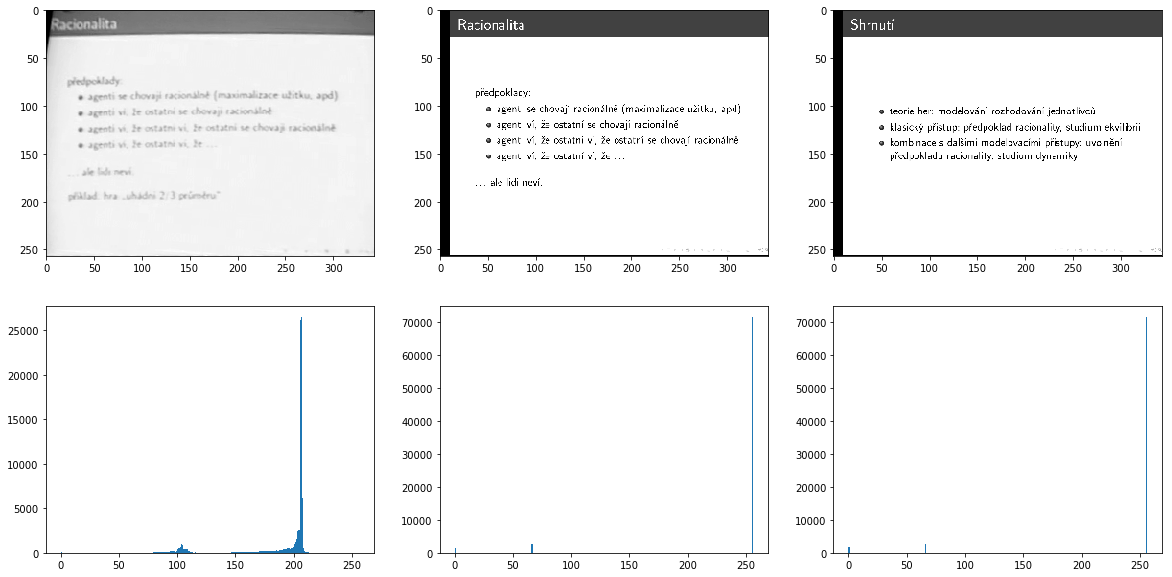

In [4]:
video = get_videos()['https://is.muni.cz/auth/el/1433/jaro2016/IV109/um/vi/?videomuni=IV109-D2-20160406.mp4']
frame = get_nth(video, 3)
screen, *_ = sorted(
    AnnotatedScreenDetector('fimu', 'd2', 'default_2004').detect(frame),
    key=lambda screen: screen.coordinates,
)
correct_page = get_nth(video.documents['slides01.pdf'], 7)
incorrect_page = get_nth(video.documents['slides01.pdf'], 20)
display(screen, correct_page, incorrect_page, 'figures/correlation-02.pdf')

## Correlation coefficients with image registration by feature matching
The below code was borrowed with minor alterations from the [Image Alignment (Feature Based) using OpenCV (C++/Python)](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) article at <https://www.learnopencv.com> by Satya Mallick.

In [5]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def align_images(screen_image, page_image):
    
    screen_image_gray = cv.cvtColor(screen_image, cv.COLOR_RGBA2GRAY)
    page_image_gray = cv.cvtColor(page_image, cv.COLOR_RGBA2GRAY)
   
    # Detect ORB features and compute descriptors.
    orb = cv.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(page_image_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(screen_image_gray, None)
   
    # Match features.
    matcher = cv.BFMatcher(cv.NORM_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
   
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
   
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
   
    # Find homography
    homography, _ = cv.findHomography(points1, points2, cv.RANSAC)

    # Use homography
    height, width, _ = screen_image.shape
    page_image_registered = cv.warpPerspective(
        page_image,
        homography,
        (width, height),
        borderMode=cv.BORDER_CONSTANT,
        borderValue=COLOR_RGBA_TRANSPARENT,
    )
   
    return page_image_registered

def display(screen, correct_page, incorrect_page, figure_pathname):
    screen_image_gray = cv.cvtColor(screen.image, cv.COLOR_RGBA2GRAY)
    screen_image_alpha = screen.image[:,:,3]

    correct_page_image = align_images(screen.image, correct_page.image(screen.width, screen.height))
    correct_page_image_gray = cv.cvtColor(correct_page_image, cv.COLOR_RGBA2GRAY)
    correct_page_image_alpha = correct_page_image[:,:,3]
    nonzero_alpha = np.minimum(screen_image_alpha, correct_page_image_alpha).nonzero()
    correct_page_pearsonr = pearsonr(screen_image_gray[nonzero_alpha], correct_page_image_gray[nonzero_alpha])
    correct_page_spearmanr = spearmanr(screen_image_gray[nonzero_alpha], correct_page_image_gray[nonzero_alpha])
    
    incorrect_page_image = align_images(screen.image, incorrect_page.image(screen.width, screen.height))
    incorrect_page_image_gray = cv.cvtColor(incorrect_page_image, cv.COLOR_RGBA2GRAY)
    incorrect_page_image_alpha = incorrect_page_image[:,:,3]
    nonzero_alpha = np.minimum(screen_image_alpha, incorrect_page_image_alpha).nonzero()
    incorrect_page_pearsonr = pearsonr(screen_image_gray[nonzero_alpha], incorrect_page_image_gray[nonzero_alpha])
    incorrect_page_spearmanr = spearmanr(screen_image_gray[nonzero_alpha], incorrect_page_image_gray[nonzero_alpha])

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1).imshow(screen_image_gray, cmap='gray')
    plt.subplot(2, 3, 2).imshow(correct_page_image_gray, cmap='gray')
    plt.subplot(2, 3, 3).imshow(incorrect_page_image_gray, cmap='gray')

    plt.subplot(2, 3, 4).hist(screen_image_gray[screen_image_alpha.nonzero()], range=(0, 256), bins=256)
    plt.subplot(2, 3, 5).hist(
        correct_page_image_gray[correct_page_image_alpha.nonzero()],
        range=(0, 256),
        bins=256,
    )
    plt.subplot(2, 3, 6).hist(
        incorrect_page_image_gray[incorrect_page_image_alpha.nonzero()],
        range=(0, 256),
        bins=256,
    )

    plt.savefig(figure_pathname)

    print("Pearson's r between left and middle images:  {}".format(*correct_page_pearsonr))
    print("Spearman's r between left and middle images: {}".format(*correct_page_spearmanr))

    print()
    
    print("Pearson's r between left and right images:  {}".format(*incorrect_page_pearsonr))
    print("Spearman's r between left and right images: {}".format(*incorrect_page_spearmanr))

Feature-based registration gives more encouraging results. Both results below are correctly matched.

Pearson's r between left and middle images:  0.910617461750877
Spearman's r between left and middle images: 0.7643819917773811

Pearson's r between left and right images:  -0.03942047318595929
Spearman's r between left and right images: -0.0008191926000750498


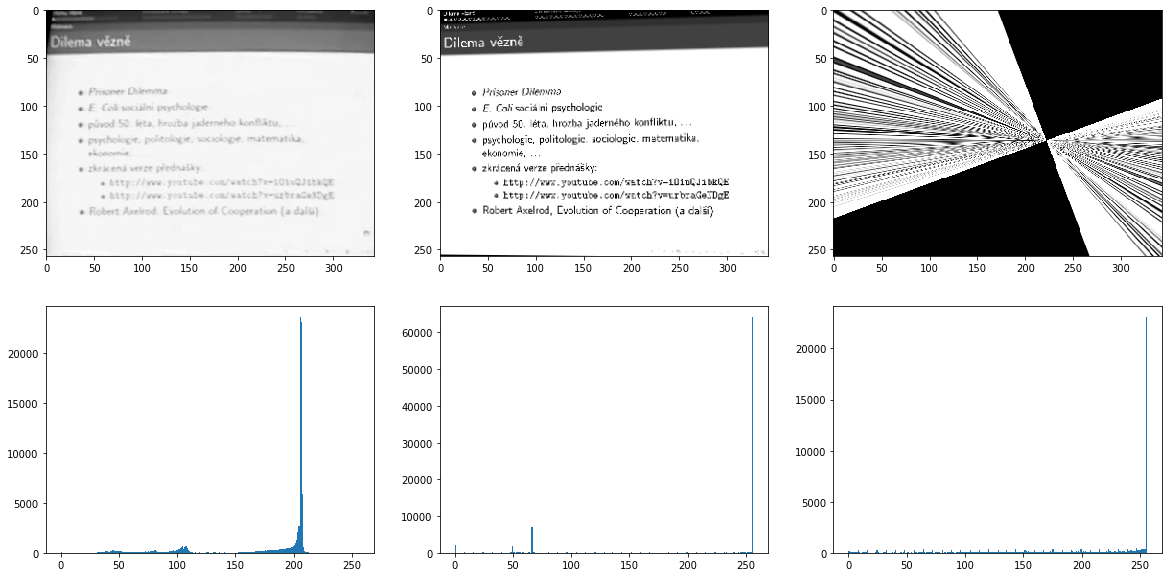

In [6]:
video = get_videos()['https://is.muni.cz/auth/el/1433/jaro2016/IV109/um/vi/?videomuni=IV109-D2-20160406.mp4']
frame = get_nth(video, 8)
screen, *_ = sorted(
    AnnotatedScreenDetector('fimu', 'd2', 'default_2004').detect(frame),
    key=lambda screen: screen.coordinates,
)
correct_page = get_nth(video.documents['slides02.pdf'], 3)
incorrect_page = get_nth(video.documents['slides01.pdf'], 7)
display(screen, correct_page, incorrect_page, 'figures/feature-matching_correlation-01.pdf')

Pearson's r between left and middle images:  0.624402095396561
Spearman's r between left and middle images: 0.4920574917403165

Pearson's r between left and right images:  0.02125316922963557
Spearman's r between left and right images: 0.03595935945173888


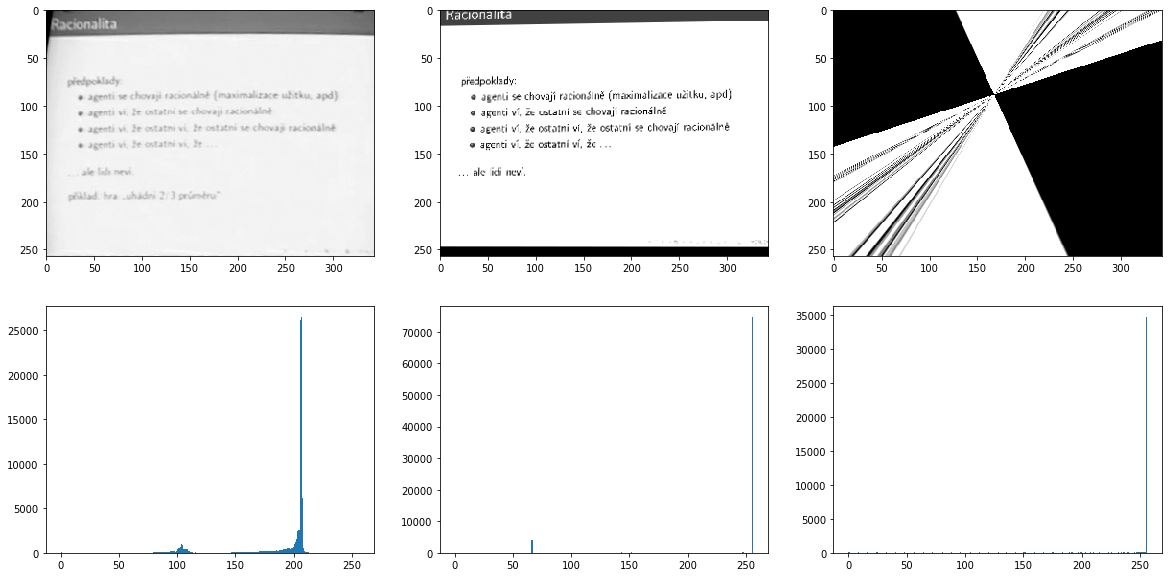

In [7]:
video = get_videos()['https://is.muni.cz/auth/el/1433/jaro2016/IV109/um/vi/?videomuni=IV109-D2-20160406.mp4']
frame = get_nth(video, 3)
screen, *_ = sorted(
    AnnotatedScreenDetector('fimu', 'd2', 'default_2004').detect(frame),
    key=lambda screen: screen.coordinates,
)
correct_page = get_nth(video.documents['slides01.pdf'], 7)
incorrect_page = get_nth(video.documents['slides01.pdf'], 20)
display(screen, correct_page, incorrect_page, 'figures/feature-matching_correlation-02.pdf')